In [7]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
folder = "kaggle-cardio/"
cardio_file = "cardio_train.csv"

df_cardio = pd.read_csv(f"{folder}{cardio_file}", sep = ";")

df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"] / 100) ** 2

def plot_column(df, col_name, min, max):
    return df[(df[col_name] > min) & (df[col_name] < max)]

df_cardio = plot_column(df_cardio, "bmi", min = 15, max = 50)

df_cardio["bmi_category"] = pd.cut(
    df_cardio["bmi"], 
    bins = [0, 25, 30, 35, 40, 1000], 
    labels = ["Normal", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], 
    right = False
)

df_cardio = plot_column(df_cardio, "ap_hi", min = 75, max = 200)

df_cardio = plot_column(df_cardio, "ap_lo", min = 50, max = 150)

In [8]:
def ap_categorizer(hi, lo):
    '''ap_categorizer() takes blood two pressure values as arguments and returns the blood pressure category'''

    if hi >= 180 or lo >= 120: return "Hypertension crisis"
    if hi >= 140 or lo >= 90: return "Stage 2 hypertension"
    if hi < 120 and lo < 80: return "Healthy"
    if hi < 130 and lo < 80: return "Elevated"
    return "Stage 1 hypertension"

df_cardio["ap_category"] = df_cardio.apply(lambda x: ap_categorizer(x["ap_hi"], x["ap_lo"]), axis = 1).astype("category")

In [9]:
df_cardio_first = df_cardio.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], axis = 1)
df_cardio_first = pd.get_dummies(df_cardio_first, columns = ["bmi_category", "ap_category", "gender"], drop_first = True)

df_cardio_second = df_cardio.drop(["bmi_category", "ap_category", "height", "weight"], axis = 1)
df_cardio_second = pd.get_dummies(df_cardio_second, columns = ["gender"], drop_first = True)

df_cardio_second.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.967120,1
1,1,20228,140,90,3,1,0,0,1,1,34.927679,0
2,2,18857,130,70,3,1,0,0,0,1,23.507805,0
3,3,17623,150,100,1,1,0,0,1,1,28.710479,1
4,4,17474,100,60,1,1,0,0,0,0,23.011177,0


In [10]:
def tvt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.5, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_first.drop(["id", "cardio"], axis = 1), df_cardio_first["cardio"])

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_second.drop(["id", "cardio"], axis = 1), df_cardio_second["cardio"])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((34130, 10), (17065, 10), (17065, 10), (34130,), (17065,), (17065,))

In [11]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [12]:
#from evolutionary_algos import EvoMLPClassifier
#classifier = EvoMLPClassifier(n = 48, hidden_layers = [8], activation = "relu", random_state = 42)
#classifier.fit(scaled_X_train, y_train, epochs = 1000, verbose = 1)

In [13]:
class EvoMLPClassifier:
    '''LATEST VERSION, TESTED WITH MULTICLASS AND BINARY'''

    def __init__(self, n = 24, hidden_layers = False, activation = "relu", lr_target = 0.04, lr_initial_decay = 60, lr_final_decay = 0.03, random_state = None):

        self.n = int(round(n / 8) * 8)
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.lr_target = lr_target
        self.lr_initial_decay = lr_initial_decay
        self.lr_final_decay = lr_final_decay

        
        if hidden_layers:
            self.hidden_layers = hidden_layers
        else:
            self.hidden_layers = False

        

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        n = self.n
        ndiv4 = n // 4

        if self.random_state != None:
            np.random.seed(self.random_state)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]
        y_train = y_train.astype("int8")

        if len(y_train.shape) == 1:
            self.multiclass = False
        elif len(y_train.shape) == 2 and y_train.shape[1] == 1:
            self.multiclass = False
            y_train = y_train.ravel()
        else:
            self.multiclass = True
            

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 2, keepdims = True)
            
            def loss_function(y_train, y_preds, sorted_indices):
                return np.mean(np.sum(-y_train * np.log10(y_preds[sorted_indices[ndiv4:]]), axis = 2), axis = 1)

        elif self.multiclass == False:
            output_activation_function = lambda x: (1 / (1 + np.exp(-x))).reshape(x.shape[:2])

            def loss_function(y_train, y_preds, sorted_indices):
                return np.mean(np.abs(y_preds[sorted_indices[ndiv4:]] - y_train), axis = 1)

        lr_target = self.lr_target
        lr_initial_decay = self.lr_initial_decay
        lr_final_decay = self.lr_final_decay

        layers = [X_train.shape[1]]

        if self.hidden_layers:
            layers = [X_train.shape[1]] + self.hidden_layers

        if self.multiclass == True:
            layers = layers + [y_train.shape[1]]
        elif self.multiclass == False:
            layers = layers + [1]

        number_of_layers_minus_one = len(layers) - 1
        
        if self.multiclass == True:
            y_preds = np.zeros((n, y_train.shape[0], y_train.shape[1]))
        elif self.multiclass == False:
            y_preds = np.zeros((n, y_train.shape[0]))

        nets_loss = np.zeros(n)
        sorted_indices = np.arange(-(ndiv4), n, 1)

        best_net_index = -1

        weights = []

        for i in range(number_of_layers_minus_one):
            weights += [np.random.normal(0, 1, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            


            forward_pass = X_train.T

            
            for j in range(number_of_layers_minus_one - 1):
                forward_pass = activation_function(weights[j][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass)
            
            forward_pass = weights[-1][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass
            
            y_preds[sorted_indices[ndiv4:]] = output_activation_function(forward_pass.transpose(0, 2, 1))

            nets_loss[sorted_indices[ndiv4:]] = loss_function(y_train, y_preds, sorted_indices)

            sorted_indices = np.argsort(nets_loss)
            mutation_sigma = math.exp(-epoch / (epochs / (lr_initial_decay * math.log10(epochs + 1)))) + lr_final_decay * math.exp(-(epoch + 1) * (1 / (epochs))) + lr_target + (-0.036 * 10 * lr_final_decay)

            for j in range(number_of_layers_minus_one):
                weights[j][sorted_indices[0 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[1 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[2 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[3 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[4 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[5 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))

            if best_net_index != sorted_indices[0]:
                best_net_index = sorted_indices[0]
                self.training_loss_history += [nets_loss[best_net_index]]
                

                self.best_net_weights = []
                for j in range(number_of_layers_minus_one):
                    self.best_net_weights += [weights[j][best_net_index]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - {mutation_sigma}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)

        elif self.multiclass == False:
            output_activation_function = lambda x: (1 / (1 + np.exp(-x))).reshape(x.shape[:1])

        forward_pass = X.T

        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)
            
        forward_pass = self.best_net_weights[-1].T @ forward_pass
            
        return output_activation_function(forward_pass.T)

In [14]:
classifier = EvoMLPClassifier(n = 48, hidden_layers = [8], activation = "relu", random_state = 42)
classifier.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 0.39374032246301394 - val_loss: 0.38968283210568444
Epoch 1 - loss: 0.3397788346408439 - val_loss: 0.33640518290534366
Epoch 3 - loss: 0.33468340103248234 - val_loss: 0.3317709969432861
Epoch 4 - loss: 0.3334523129568803 - val_loss: 0.3340965631975216
Epoch 5 - loss: 0.30126881765951924 - val_loss: 0.301819874015624
Epoch 6 - loss: 0.29681837002558825 - val_loss: 0.29804901352497487
Epoch 7 - loss: 0.2937070206555696 - val_loss: 0.2953613057663528
Epoch 8 - loss: 0.2886923266383625 - val_loss: 0.2883959141595153
Epoch 9 - loss: 0.2846693337818226 - val_loss: 0.2845784549059798
Epoch 10 - loss: 0.2826359437342934 - val_loss: 0.28264373722908975
Epoch 11 - loss: 0.28206415929834955 - val_loss: 0.2834567176642941
Epoch 12 - loss: 0.27939242712663925 - val_loss: 0.2790168244993552
Epoch 13 - loss: 0.2775301777112635 - val_loss: 0.2784404088016199
Epoch 14 - loss: 0.2768329184535879 - val_loss: 0.2765330683131002
Epoch 15 - loss: 0.2758143373228325 - val_loss: 0.277093023761

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      8683
           1       0.74      0.69      0.72      8382

    accuracy                           0.73     17065
   macro avg       0.73      0.73      0.73     17065
weighted avg       0.73      0.73      0.73     17065



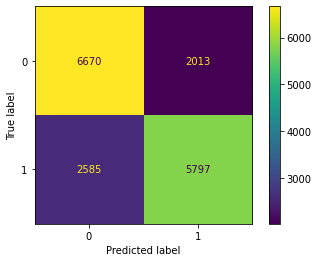

In [9]:
y_pred = classifier.predict(scaled_X_test)
y_pred = (y_pred > 0.5) * 1

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [16]:
np.random.seed(42)

a = np.random.randint(1, 5, (10, 2))
a

array([[3, 4],
       [1, 3],
       [3, 4],
       [1, 1],
       [3, 2],
       [3, 3],
       [3, 3],
       [4, 1],
       [4, 4],
       [4, 3]])

In [18]:
b = np.arange(0, a.shape[0])
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [111]:
c = np.random.choice(b, 4, replace = False)
c, a[b[c]], np.delete(a, b[c])


(array([0, 2, 8, 6]),
 array([[3, 4],
        [3, 4],
        [4, 4],
        [3, 3]]),
 array([4, 3, 3, 4, 1, 2, 3, 3, 3, 3, 4, 1, 4, 4, 4, 3]))